<a href="https://colab.research.google.com/github/saritmaitra/AL-VAR-VECM-/blob/main/AL_VAR_EURUSD_FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings
from pandas import DataFrame, merge, concat

In [2]:
from google.colab import files
uploaded = files.upload()

Saving AL_final_data.csv to AL_final_data.csv


In [13]:
df = pd.read_csv("AL_final_data.csv")
df.head()

<IPython.core.display.Javascript object>

,Unnamed: 0,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
0,0,2020-05-01 00:00:00,2877.12,1094465.00,1258140.00,1695.85,8846.12,107301000.00
1,1,2020-05-01 00:01:00,2875.38,1094215.00,1257935.00,1695.60,8841.25,107368000.00
2,2,2020-05-01 00:02:00,2874.62,1094165.00,1257765.00,1695.65,8837.75,107376500.00
3,3,2020-05-01 00:03:00,2874.12,1094115.00,1257565.00,1695.40,8836.75,107381500.00
4,4,2020-05-01 00:04:00,2875.25,1094190.00,1257535.00,1694.85,8841.12,107376500.00


In [14]:
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df.tail()

,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
29340,2020-05-29 20:56:00,3027.25,1111740.00,1235400.00,1731.50,9588.62,107675000.00
29341,2020-05-29 20:57:00,3027.25,1111750.00,1235450.00,1731.20,9588.50,107830000.00
29342,2020-05-29 20:58:00,3027.25,1111650.00,1235450.00,1731.45,9588.62,107830000.00
29343,2020-05-29 20:59:00,3027.25,1113400.00,1235450.00,1731.30,9587.38,107835000.00
29344,2020-05-29 21:00:00,3027.25,1113400.00,1237150.00,1731.35,9591.12,107835000.00


In [15]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [16]:
# spliting train/test
nobs = 120 # keeping 60 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
print(train_var.shape); print(test_var.shape);

# transfoming training data set
train_trans = train_var.diff().dropna() # differencing
print('Description of diff data:'); print(train_trans.describe());

(29225, 6)
(120, 6)
Description of diff data:
            es    eurusd    gbpusd       gc       nq      usdjpy
count 29224.00  29224.00  29224.00 29224.00 29224.00    29224.00
mean      0.00      0.55     -0.86     0.00     0.02       16.19
std       1.12    289.07    335.11     0.52     3.71    48008.82
min     -37.75 -18615.00 -18420.00    -9.15  -131.50 -4778500.00
25%      -0.50    -50.00   -100.00    -0.20    -1.50    -5500.00
50%       0.00      0.00      0.00     0.00     0.00        0.00
75%       0.50     50.00    100.00     0.20     1.62     5500.00
max      26.88  18290.00  17970.00    11.95    84.75  4752500.00


## Lag order selection

Iteratively fitting increasing orders of VAR model to identify the order that gives a model with least AIC.

In [17]:
from statsmodels.tsa.api import VAR
pd.options.display.float_format = "{:.2f}".format
model = VAR(train_trans.values)
for i in [1,2,3,4,5,6,7,8,9,11,12,13,14,15]:
    res = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', res.aic)
    print('BIC : ', res.bic)
    print('FPE : ', res.fpe)
    print('HQIC: ', res.hqic, '\n')

<IPython.core.display.Javascript object>

Lag Order = 1
AIC :  44.19562983789861
BIC :  44.207533950298995
FPE :  1.5628531155798278e+19
HQIC:  44.19945418768872 

Lag Order = 2
AIC :  44.13410656826821
BIC :  44.156214870782755
FPE :  1.4695993339990856e+19
HQIC:  44.141209157446625 

Lag Order = 3
AIC :  44.11592521550747
BIC :  44.1482383222285
FPE :  1.4431214623184474e+19
HQIC:  44.12630625204882 

Lag Order = 4
AIC :  44.10859715820085
BIC :  44.15111568327942
FPE :  1.4325848411965825e+19
HQIC:  44.1222568501002 

Lag Order = 5
AIC :  44.106030196989614
BIC :  44.15875475463548
FPE :  1.4289121705459634e+19
HQIC:  44.122968752262445 

Lag Order = 6
AIC :  44.104889110681995
BIC :  44.16782031516368
FPE :  1.4272825931328674e+19
HQIC:  44.12510673736424 

Lag Order = 7
AIC :  44.103883961707965
BIC :  44.1770224273527
FPE :  1.425848688865977e+19
HQIC:  44.127380867855976 

Lag Order = 8
AIC :  44.10371089313335
BIC :  44.187057234327156
FPE :  1.4256019493421416e+19
HQIC:  44.13048728682394 

Lag Order = 9
AIC :  44.104

- AIC drops to lowest at lag 8, then increases at lag 9 and then keeps increrasing. We will fo with lag 8 model.
- BIC drops to lowest at lag 3
- FPE drops to lowest at lag 8
- HQIC drops to lowest at lag 4

We shall try with lag 8 and lag3 to check which models proves better output.

In [18]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,44.45,44.45,2.017e+19,44.45
1,44.20,44.21,1.565e+19,44.20
2,44.14,44.16,1.471e+19,44.14
3,44.12,44.15,1.444e+19,44.13
4,44.11,44.15,1.434e+19,44.12
5,44.11,44.16,1.430e+19,44.12
6,44.11,44.17,1.428e+19,44.13
7,44.10,44.18,1.427e+19,44.13
8,44.10,44.19,1.426e+19,44.13
9,44.11,44.20,1.428e+19,44.14


In [19]:
import statsmodels.tsa.api as smt
# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model = smt.VAR(endog = train_trans).fit(maxlags = 8)
model.summary()

<IPython.core.display.Javascript object>

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Nov, 2020
Time:                     08:09:02
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    44.1871
Nobs:                     29216.0    HQIC:                   44.1305
Log likelihood:          -892707.    FPE:                1.42560e+19
AIC:                      44.1037    Det(Omega_mle):     1.41134e+19
--------------------------------------------------------------------
Results for equation es
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.004929         0.006533            0.755           0.451
L1.es             0.009702         0.012578            0.771           0.440
L1.eurusd         0.000107         0.000025            4.223           0.000
L1

- Top of the table shows the information for the model as a whole, including values of the information criteria, 
- Further down we shows the coefficient estimates and goodness-of-fit measures for each of the equations separately. 
- Each regression equation is separated by a horizontal line.

### Durbin Watson Statistic
Checking for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic. If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series. So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.


In [20]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model.resid)

for col, val in zip(train_var.columns, out):
    print((col), ':', round(val, 2))

es : 2.0
eurusd : 2.0
gbpusd : 2.0
gc : 2.0
nq : 2.0
usdjpy : 2.0


This is to determine the existence of multi-colinearity where variables are highly correlated. The statistic is a values between 0-4 and value 2 is idea, which means there is ni auto-correlation among the variables in the model.

The serial correlation looks alright. Let’s proceed with the forecast.

In [21]:
print('GBPUSD-> EURUSD')
ca_1 = model.test_causality(causing=['gbpusd'], caused=['eurusd'], kind='wald',signif=0.05 )
print(ca_1)
print("**********************")
print('GBPUSD-> USDJPY')
ca_2 = model.test_causality(causing=['gbpusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_2)
print("**********************")
print('GBPUSD -> USDJPY, EURUSD')
ca_3 = model.test_causality(causing=['gbpusd'], caused=['usdjpy', 'eurusd'], kind='wald',signif=0.05 )
print(ca_3)
print("**********************")
print('EURUSD -> USDJPY')
ca_4 = model.test_causality(causing=['eurusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")
print('EURUSD -> GBPUSD, USDJPY')
ca_5 = model.test_causality(causing=['eurusd'], caused=['gbpusd', 'usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")

GBPUSD-> EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause eurusd: reject at 5% significance level. Test statistic: 488.025, critical value: 15.507>, p-value: 0.000>
**********************
GBPUSD-> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statistic: 5.745, critical value: 15.507>, p-value: 0.676>
**********************
GBPUSD -> USDJPY, EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause [usdjpy, eurusd]: reject at 5% significance level. Test statistic: 492.358, critical value: 26.296>, p-value: 0.000>
**********************
EURUSD -> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: eurusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statis

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

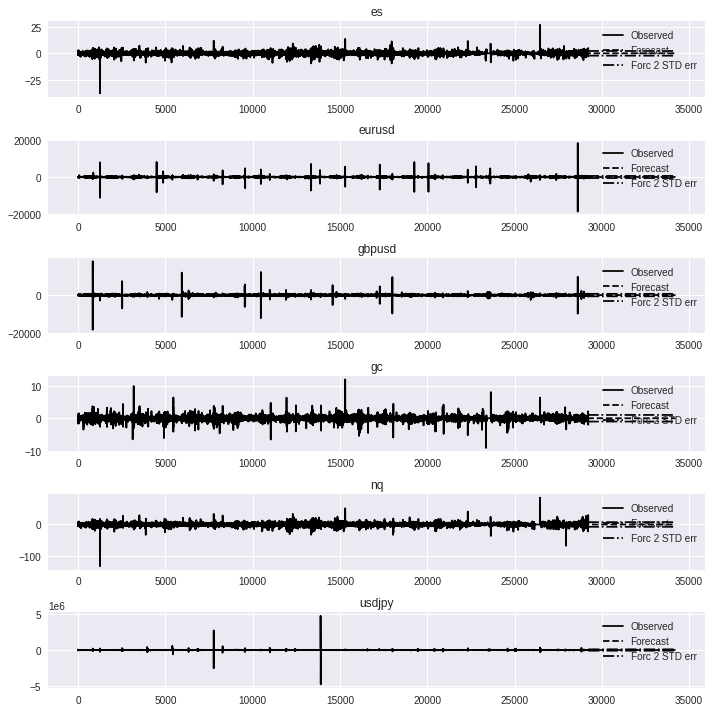

In [22]:
plt.style.use('seaborn')
model.plot_forecast(5000)
plt.tight_layout()

## Forecasting

In [23]:
#lag_order = res.k_ar
#res.forecast(train_trans.values[-lag_order:], 30)

pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model.k_ar
print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
print(input_data)

<IPython.core.display.Javascript object>

8
[[-1.7500e+00 -1.5000e+02 -2.1000e+02 -5.0000e-02 -1.2500e+01  1.2500e+04]
 [ 4.5000e+00  2.5000e+02  5.0500e+02 -2.0000e-01  2.8750e+01  1.0500e+04]
 [-7.5000e-01  1.0500e+02  3.0000e+02 -1.5000e-01 -7.5000e+00  2.5000e+03]
 [ 2.2500e+00  1.9500e+02  4.9500e+02  0.0000e+00  1.3625e+01 -2.5000e+03]
 [ 4.2500e+00  4.5000e+02  4.0500e+02 -1.3500e+00  2.5375e+01 -5.5000e+03]
 [ 5.0000e+00  4.7500e+02  7.4500e+02 -1.7000e+00  2.9875e+01  0.0000e+00]
 [ 1.5000e+00  1.5000e+01 -4.5000e+02 -2.0000e+00  1.0125e+01  3.0000e+03]
 [ 3.1250e+00  4.4500e+02  4.0500e+02  2.0000e-01  1.6500e+01 -3.1500e+04]]


In [24]:
fc = model.forecast(y = input_data, steps=nobs)
pred = DataFrame(fc, columns = train_var.columns)
pred

,es,eurusd,gbpusd,gc,nq,usdjpy
0,-0.04,-264.86,-10.16,0.18,0.40,5957.90
1,-0.03,-36.88,50.91,-0.03,0.23,2319.04
2,-0.30,-11.42,20.87,0.12,-0.52,1969.39
3,-0.28,-46.72,-4.32,0.06,-0.43,741.64
4,-0.32,-22.35,-44.19,0.06,-0.72,-2605.70
...,...,...,...,...,...,...
115,0.00,0.55,-0.84,0.00,0.02,14.73
116,0.00,0.55,-0.84,0.00,0.02,14.73
117,0.00,0.55,-0.84,0.00,0.02,14.73
118,0.00,0.55,-0.84,0.00,0.02,14.73


### Inverse transformation

In [25]:
pred['eurusd_pred'] = train_var['eurusd'].iloc[-1] + pred.eurusd.cumsum()
pred.index = test_var.index
pred

,es,eurusd,gbpusd,gc,nq,usdjpy,eurusd_pred
timestamp,,,,,,,
2020-05-29 19:01:00,-0.04,-264.86,-10.16,0.18,0.40,5957.90,1110145.14
2020-05-29 19:02:00,-0.03,-36.88,50.91,-0.03,0.23,2319.04,1110108.27
2020-05-29 19:03:00,-0.30,-11.42,20.87,0.12,-0.52,1969.39,1110096.85
2020-05-29 19:04:00,-0.28,-46.72,-4.32,0.06,-0.43,741.64,1110050.13
2020-05-29 19:05:00,-0.32,-22.35,-44.19,0.06,-0.72,-2605.70,1110027.78
...,...,...,...,...,...,...,...
2020-05-29 20:56:00,0.00,0.55,-0.84,0.00,0.02,14.73,1110079.65
2020-05-29 20:57:00,0.00,0.55,-0.84,0.00,0.02,14.73,1110080.20
2020-05-29 20:58:00,0.00,0.55,-0.84,0.00,0.02,14.73,1110080.75


## Forcast validation

In [28]:
# EURUSD forcast validation
eur_usd = concat([test_var['eurusd'], pred['eurusd_pred']], axis=1)
eur_usd = eur_usd.sort_values(by='timestamp', ascending=False)
eur_usd['accuracy'] = round(eur_usd.apply(lambda row: row.eurusd_pred / 
                                            row.eurusd *100, axis = 1),2)
eur_usd['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in eur_usd['accuracy']], 
                                     index = eur_usd.index)
eur_usd = eur_usd.round(decimals=3)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
eur_usd.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_pred']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_pred,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110081.845000,99.70%
2020-05-29 20:59:00,1113400.000000,1110081.297000,99.70%
2020-05-29 20:58:00,1111650.000000,1110080.749000,99.86%
2020-05-29 20:57:00,1111750.000000,1110080.201000,99.85%
2020-05-29 20:56:00,1111740.000000,1110079.653000,99.85%
2020-05-29 20:55:00,1110660.000000,1110079.105000,99.95%
2020-05-29 20:54:00,1110785.000000,1110078.557000,99.94%
2020-05-29 20:53:00,1110845.000000,1110078.009000,99.93%
2020-05-29 20:52:00,1110745.000000,1110077.461000,99.94%


## Accuracy Metrics:

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# score eur_usd
r_squared = r2_score(eur_usd['eurusd'], eur_usd['eurusd_pred'])
mae = mean_absolute_error(eur_usd['eurusd_pred'], eur_usd['eurusd'])
mse = mean_squared_error(eur_usd['eurusd_pred'], eur_usd['eurusd'])
rmse = np.sqrt(mse)
msle = mean_squared_log_error(eur_usd['eurusd'], eur_usd['eurusd_pred'])
sum = DataFrame(index = ['R-squared', 'Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean squared log Error'])
sum['Accuracy metrics : EURUSD'] = [r_squared, mae, mse, rmse, msle]
sum


<IPython.core.display.Javascript object>

,Accuracy metrics : EURUSD
R-squared,0.03
Mean Absolute Error,476.19
Mean squared error,501113.02
Root mean squared error,707.89
Mean squared log Error,0.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

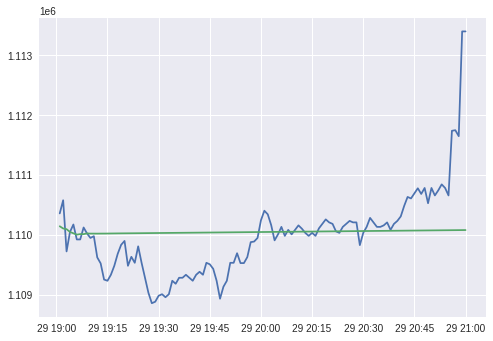

In [34]:
plt.plot(eur_usd.eurusd)
plt.plot(eur_usd.eurusd_pred)
plt.show()